# Satija lab Using Seurat with multimodal data

In [2]:
library(Seurat)
library(ggplot2)
library(patchwork)

Attaching SeuratObject



In [4]:
# Step 1: load in data

# multimodal analysis = the ability to make simultaneous measurements of multiple data types from the same cell
# For example, CITE-seq enables the simultaneous measurements of transcriptomes and cell-surface proteins from the same cell
# another example is the paired measurements of cellular transcriptome and chromatin accessibility (i.e scRNA-seq+scATAC-seq)
# Other modalities that can be measured alongside cellular transcriptomes include genetic perturbations, cellular methylomes, and hashtag oligos from Cell Hashing

# here, we create a multimodal Seurat object and perform an initial analysis
# For example, we demonstrate how to cluster a CITE-seq dataset on the basis of the measured cellular transcriptomes and subsequently discover cell surface proteins that are enriched in each cluster
# We note that Seurat4 also enables more advanced techniques for the analysis of multimodal data, in particular the application of our Weighted Nearest Neighbors (WNN) approach that enables simultaneous clustering of cells based on a weighted combination of both modalities
# Here, we analyze a dataset of 8,617 cord blood mononuclear cells (CBMCs), where transcriptomic measurements are paired with abundance estimates for 11 surface proteins, whose levels are quantified with DNA-barcoded antibodies

# First, we load in two count matrices : one for the RNA measurements, and one for the antibody-derived tags (ADT)
# Load in the RNA UMI matrix
# Note that this dataset also contains ~5% of mouse cells, which we can use as negative controls for the protein measurements
# For this reason, the gene expression matrix has HUMAN_ or MOUSE_ appended to the beginning of each gene.
cbmc.rna <- as.sparse(read.csv(file = "../data/rna.csv.gz", sep = ",", header = TRUE, row.names = 1))

# To make life a bit easier going forward, we're going to discard all but the top 100 most highly expressed mouse genes, and remove the 'HUMAN_' from the CITE-seq prefix
cbmc.rna <- CollapseSpeciesExpressionMatrix(cbmc.rna)

# Load in the ADT UMI matrix
cbmc.adt <- as.sparse(read.csv(file = "../data/adt.csv.gz", sep = ",", header = TRUE, row.names = 1))

# Note that since measurements were made in the same cells, the two matrices have identical column names
all.equal(colnames(cbmc.rna), colnames(cbmc.adt))

[1] TRUE

In [5]:
# Step 2: Setup a Seurat object, add the RNA and protein data
# Now we create a Seurat object, and add the ADT data as a second assay

# creates a Seurat object based on the scRNA-seq data
cbmc <- CreateSeuratObject(counts = cbmc.rna)

# We can see that by default, the cbmc object contains an assay storing RNA measurement
Assays(cbmc)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


[1] "RNA"

In [6]:
# create a new assay to store ADT information
adt_assay <- CreateAssayObject(counts = cbmc.adt)

# add this assay to the previously created Seurat object
cbmc[["ADT"]] <- adt_assay

# Validate that the object now contains multiple assays
Assays(cbmc)

[1] "RNA" "ADT"

In [7]:
# Extract a list of features measured in the ADT assay
rownames(cbmc[["ADT"]])

[1] "CD3"    "CD4"    "CD8"    "CD45RA" "CD56"   "CD16"   "CD10"   "CD11c" 
 [9] "CD14"   "CD19"   "CD34"   "CCR5"   "CCR7"

In [9]:
# Note that we can easily switch back and forth between the two assays to specify the default for visualization and analysis

# List the current default assay
DefaultAssay(cbmc)

# Switch the default to ADT
DefaultAssay(cbmc) <- "ADT"
DefaultAssay(cbmc)

[1] "RNA"

[1] "ADT"

In [10]:
# Step 3: Cluster cells on the basis of their scRNA-seq profiles

# Note that all operations below are performed on the RNA assay Set and verify that the default assay is RNA
DefaultAssay(cbmc) <- "RNA"
DefaultAssay(cbmc)

[1] "RNA"

Centering and scaling data matrix

Computing nearest neighbor graph

Computing SNN

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
22:17:29 UMAP embedding parameters a = 0.9922 b = 1.112

22:17:29 Read 8617 rows and found 30 numeric columns

22:17:29 Using Annoy for neighbor search, n_neighbors = 30

22:17:29 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

22:17:30 Writing NN index file to temp file /tmp/RtmpeWL2NC/filebd822ec23df6

22:17:30 Searching Annoy index using 1 thread, search_k = 3000

22:17:32 Annoy recall = 100%

22:17:33 

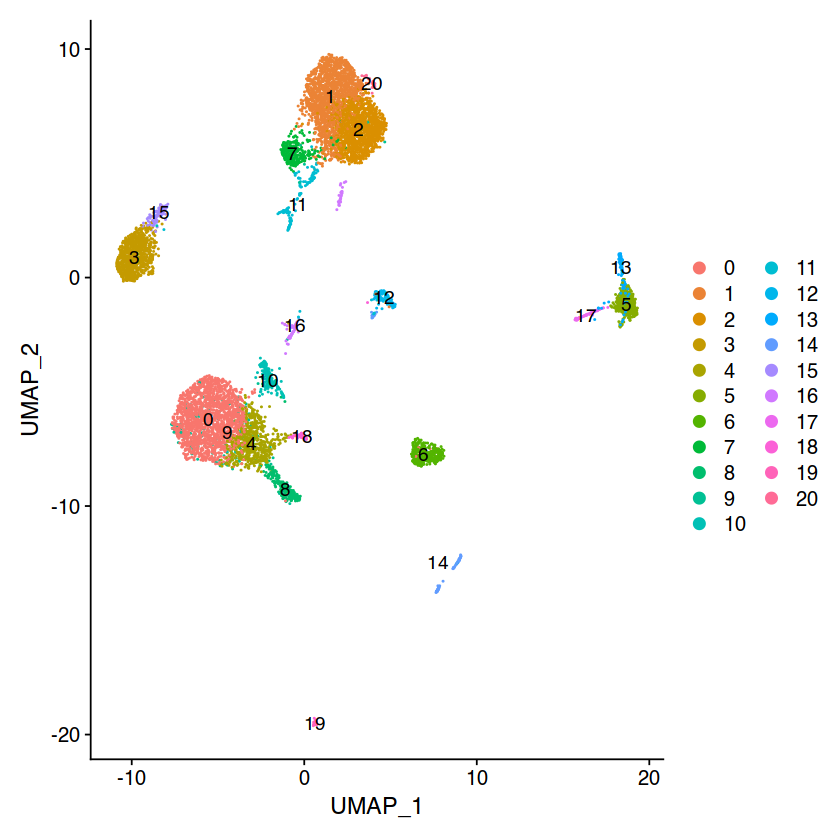

In [11]:
# perform visualization and clustering steps
cbmc <- NormalizeData(cbmc)
cbmc <- FindVariableFeatures(cbmc)
cbmc <- ScaleData(cbmc)
cbmc <- RunPCA(cbmc, verbose = FALSE)
cbmc <- FindNeighbors(cbmc, dims = 1:30)
cbmc <- FindClusters(cbmc, resolution = 0.8, verbose = FALSE)
cbmc <- RunUMAP(cbmc, dims = 1:30)
DimPlot(cbmc, label = TRUE)

Normalizing across cells

Normalizing across cells



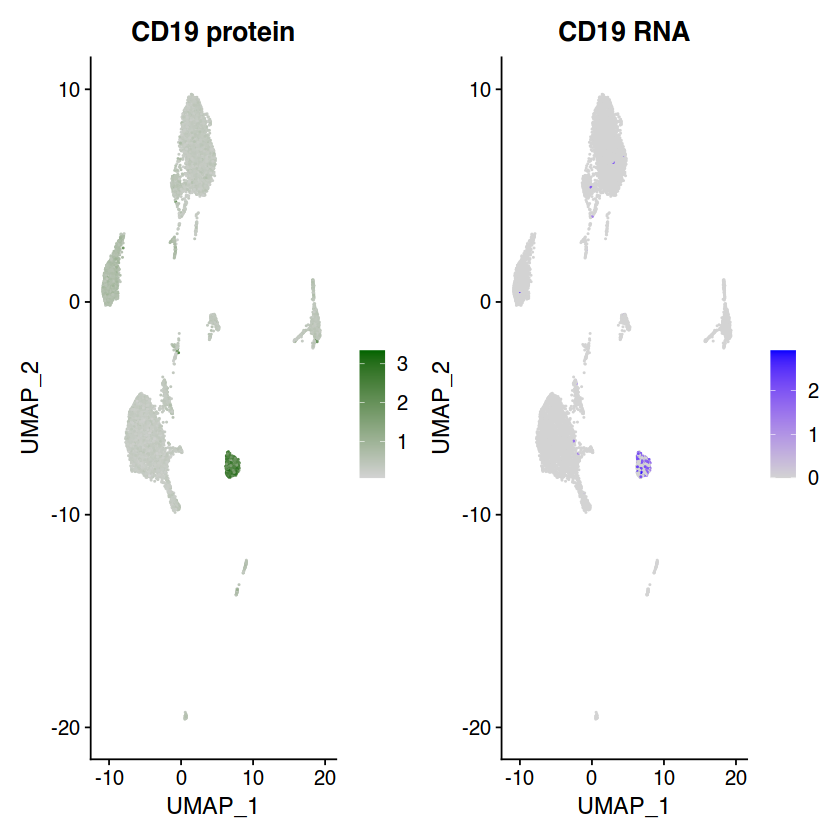

In [12]:
# Step 4: Visualize multiple modalities side-by-side

# with clusters from scRNA-seq profiles, we can visualize the expression of either protein or RNA molecules in our dataset
# Importantly, Seurat provides a couple ways to switch between modalities, and specify which modality you are interested in analyzing or visualizing
# This is particularly important as, in some cases, the same feature can be present in multiple modalities - for example this dataset contains independent measurements of the B cell marker CD19 (both protein and RNA levels)

# Normalize ADT data,
DefaultAssay(cbmc) <- "ADT"
cbmc <- NormalizeData(cbmc, normalization.method = "CLR", margin = 2)
DefaultAssay(cbmc) <- "RNA"

# Note that the following command is an alternative but returns the same result
cbmc <- NormalizeData(cbmc, normalization.method = "CLR", margin = 2, assay = "ADT")

# Now, we will visualize CD14 levels for RNA and protein By setting the default assay, we can visualize one or the other
DefaultAssay(cbmc) <- "ADT"
p1 <- FeaturePlot(cbmc, "CD19", cols = c("lightgrey", "darkgreen")) + ggtitle("CD19 protein")
DefaultAssay(cbmc) <- "RNA"
p2 <- FeaturePlot(cbmc, "CD19") + ggtitle("CD19 RNA")

# place plots side-by-side
p1 | p2

In [14]:
# Alternately, we can use specific assay keys to specify a specific modality Identify the key for the RNA and protein assays
Key(cbmc[["RNA"]])
Key(cbmc[["ADT"]])

[1] "rna_"

[1] "adt_"

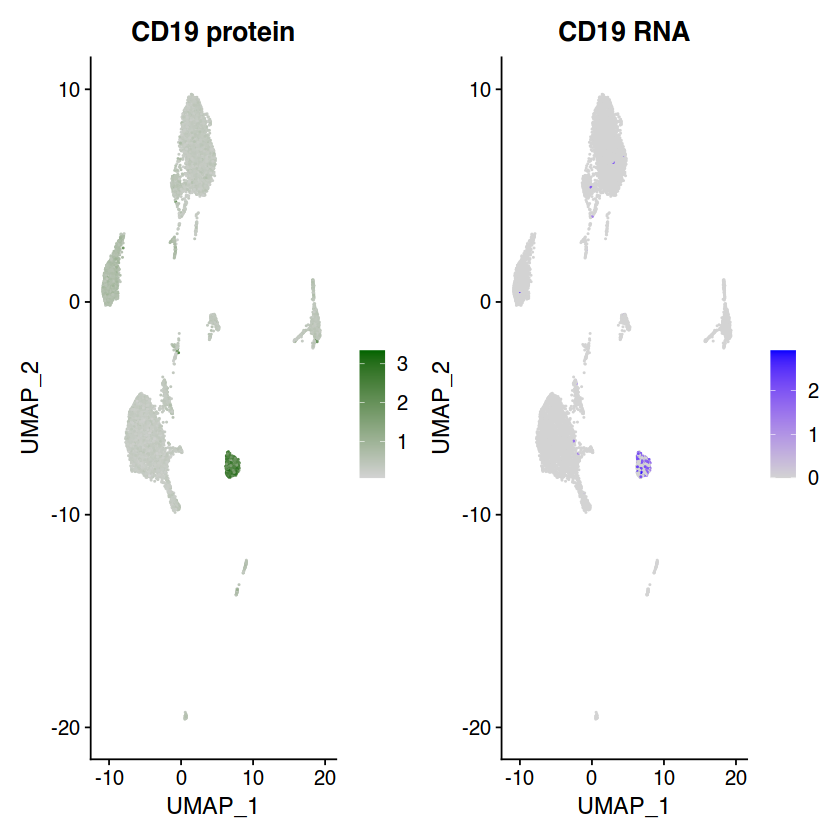

In [15]:
# Now, we can include the key in the feature name, which overrides the default assay
p1 <- FeaturePlot(cbmc, "adt_CD19", cols = c("lightgrey", "darkgreen")) + ggtitle("CD19 protein")
p2 <- FeaturePlot(cbmc, "rna_CD19") + ggtitle("CD19 RNA")
p1 | p2

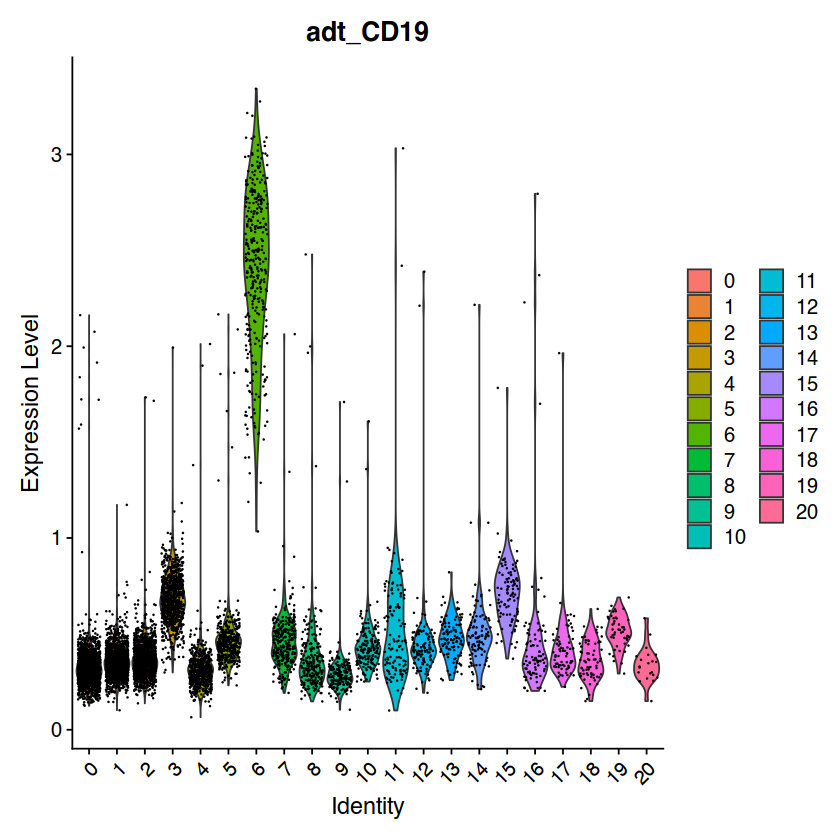

In [16]:
# Step 5: Identify cell surface markers for scRNA-seq clusters

# We can leverage our paired CITE-seq measurements to help annotate clusters derived from scRNA-seq and to identify both protein and RNA markers.

# as we know that CD19 is a B cell marker, we can identify cluster 6 as expressing CD19 on the surface
VlnPlot(cbmc, "adt_CD19")

In [17]:
# we can also identify alternative protein and RNA markers for this cluster through differential expression
adt_markers <- FindMarkers(cbmc, ident.1 = 6, assay = "ADT")
rna_markers <- FindMarkers(cbmc, ident.1 = 6, assay = "RNA")

head(adt_markers)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CD19,2.067533e-215,1.2787751,1,1,2.687793e-214
CD45RA,8.106076e-109,0.4117172,1,1,1.053790e-107
CD4,1.123162e-107,-0.7255977,1,1,1.460110e-106
CD14,7.212876e-106,-0.5060496,1,1,9.376739e-105
CD3,1.639633e-87,-0.6565471,1,1,2.131523e-86
CD8,1.042859e-17,-0.3001131,1,1,1.355716e-16


In [18]:
head(rna_markers)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BANK1,0,1.963277,0.456,0.015,0
CD19,0,1.563124,0.351,0.004,0
CD22,0,1.503809,0.284,0.007,0
CD79A,0,4.177162,0.965,0.045,0
CD79B,0,3.774579,0.944,0.089,0
FCRL1,0,1.188813,0.222,0.002,0


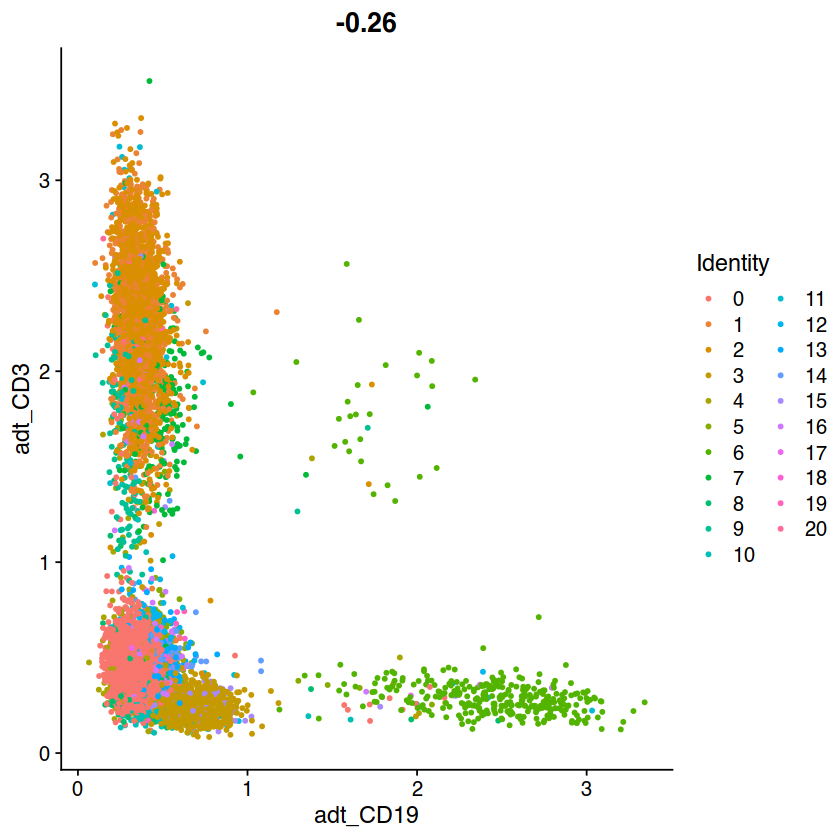

In [19]:
# Step 6: Additional visualizations of multimodal data
# Draw ADT scatter plots (like biaxial plots for FACS)
# Note that you can even 'gate' cells if desired by using HoverLocator and FeatureLocator
FeatureScatter(cbmc, feature1 = "adt_CD19", feature2 = "adt_CD3")

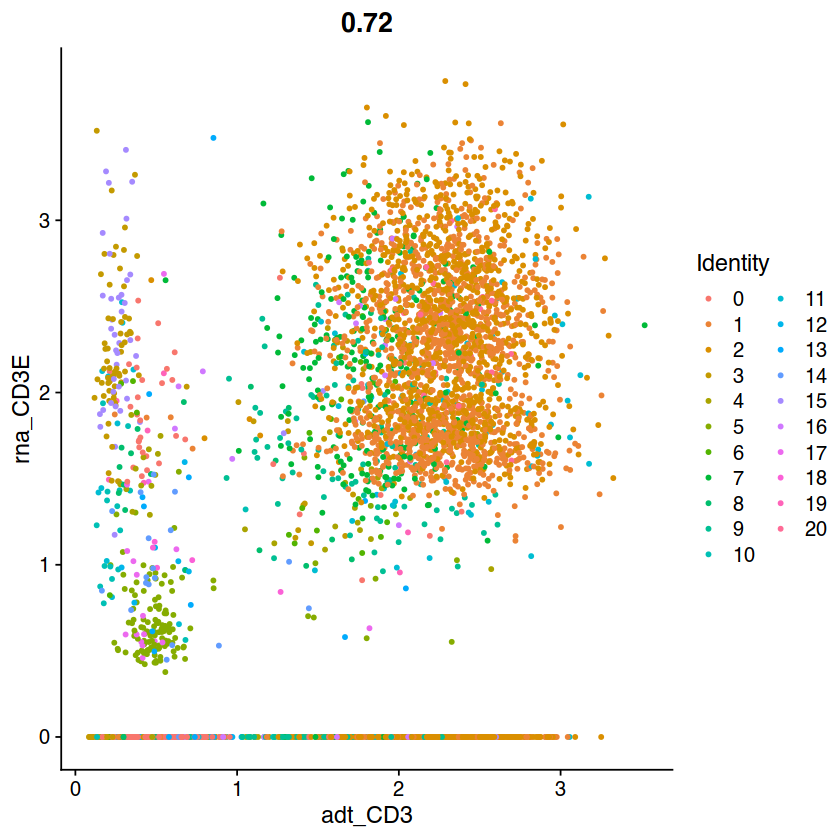

In [20]:
# view relationship between protein and RNA
FeatureScatter(cbmc, feature1 = "adt_CD3", feature2 = "rna_CD3E")

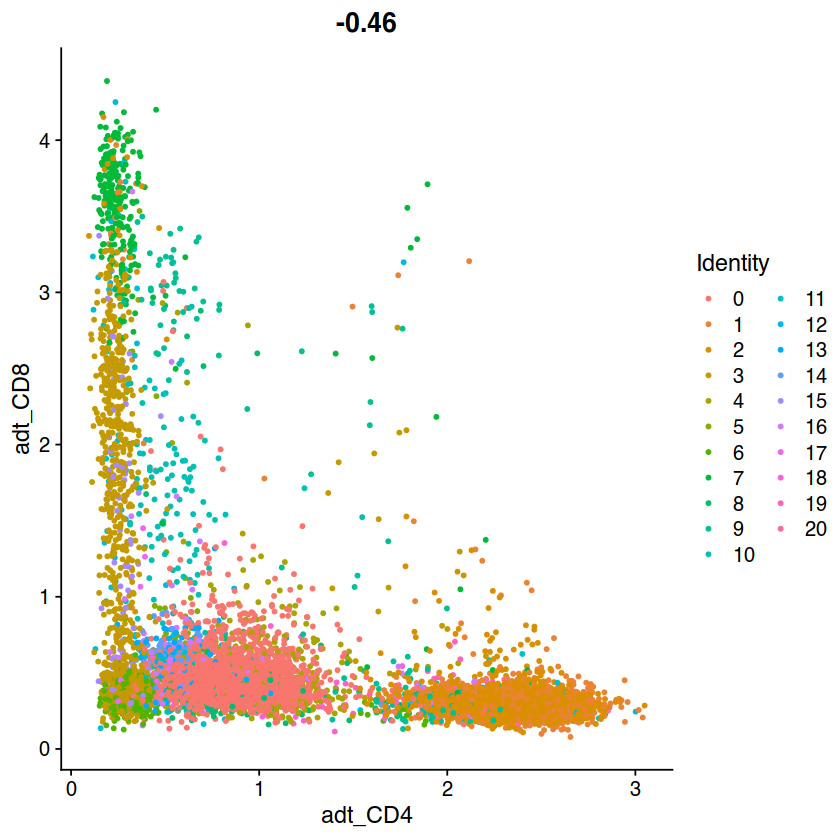

In [21]:
FeatureScatter(cbmc, feature1 = "adt_CD4", feature2 = "adt_CD8")

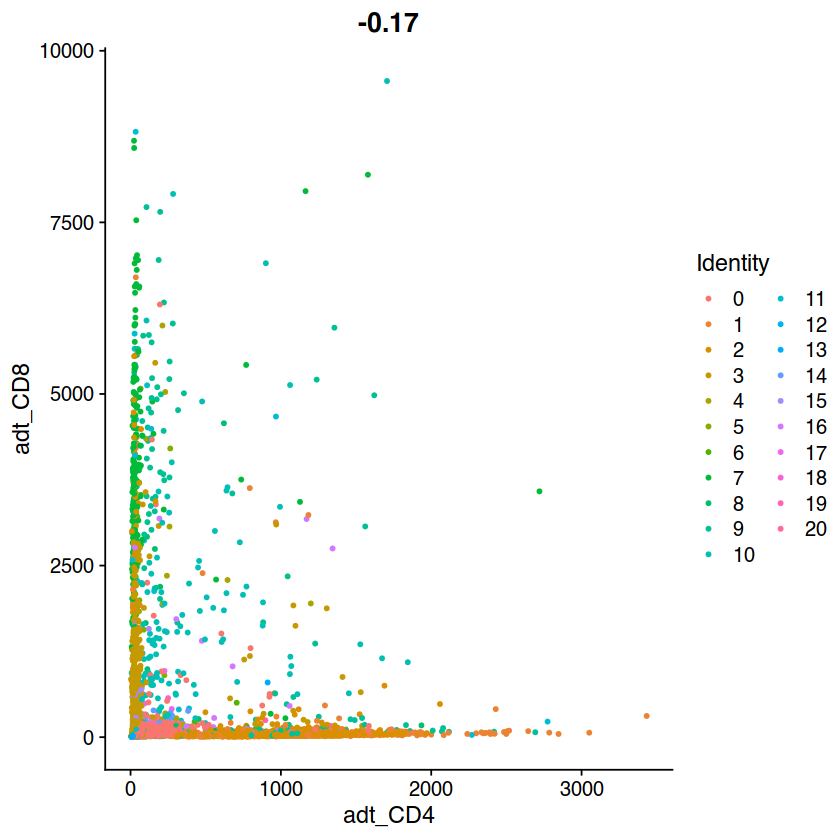

In [22]:
# Let's look at the raw (non-normalized) ADT counts
# You can see the values are quite high, particularly in comparison to RNA values
# This is due to the significantly higher protein copy number in cells, which significantly reduces 'drop-out' in ADT data
FeatureScatter(cbmc, feature1 = "adt_CD4", feature2 = "adt_CD8", slot = "counts")

In [ ]:
# Step 7: Loading data from 10X multi-modal experiments
# big files, might skip for now...
